#### Pakkar

In [1]:
# Our Libraries 
from ourModules import text_processor
from ourModules import toxic_comment_Classifier

/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [228]:
# Libraries ---------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from tensorflow.python.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.optimizers import Adadelta

# # %tensorflow_version 1.x
# import tensorflow
# print(tensorflow.__version__)
import tensorflow as tf

In [5]:
tf.compat.v1.disable_eager_execution()

#### Innlestur gagna

In [111]:


train_data = pd.read_csv('data/train.csv',delimiter=',')
train_data.drop('id',axis=1,inplace=True) # Id er gagnslaust til ad spa
# test_labeled_data = pd.read_csv('data/test_labels.csv',delimiter=',') # Will most likely not be used



### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [122]:
# Nota þetta til að testa loka módelið
cols = list(train_data)
X_train_data = train_data.drop(columns = cols[1:])
y_train_data = train_data.drop(columns = cols[:1])

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=12)


['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(127656, 1) (127656, 6)
(31915, 1) (31915, 6)


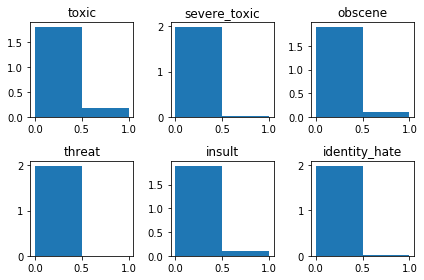

Number of instances marked with toxic: 12143 or 9.51%
Number of instances marked with severe_toxic: 1265 or 0.99%
Number of instances marked with obscene: 6714 or 5.26%
Number of instances marked with threat: 387 or 0.30%
Number of instances marked with insult: 6275 or 4.92%
Number of instances marked with identity_hate: 1117 or 0.88%


In [225]:
# Visualize distribution of y
n_bins = 2
y_train_np = y_train.to_numpy()

fig, axes = plt.subplots(nrows=2, ncols=3)
axs = axes.flatten()
i = 0
for col in cols[1:]:
    axs[i].hist(y_train[col], n_bins, density=True, histtype='bar')
    axs[i].set_title(col)
    i +=1
fig.tight_layout()
plt.show()
# Notice skewed dataset
for col in cols[1:]:
    cnt = np.count_nonzero(y_train[col])
    print('Number of instances marked with {}: {} or {:.2%}'.format(col, cnt, cnt/y_train_np.shape[0]) )

In [215]:
# n,m = y_train_np.shape
y_pred = np.zeros(n)

rowindx, colindx = np.nonzero(y_train_np)
rwi = np.unique(rowindx)
print('Number of rows with at least one none-zero value ', len(rwi))
non_zero_y_train = y_train_np[rwi]
for i in range(m):
    print('All-zero guess accuracy on data for {} is: {:.3f}'.format(cols[i+1], np.average(y_pred == y_train_np[:, i])))
    print('All-zero guess accuracy for {} but all-zero-rows removed is: {:.3f}'.format(cols[i+1],
                                                                np.average(y_pred[rwi] == non_zero_y_train[:, i])))
    print('-'*100)

Number of rows with at least one none-zero value  12900
All-zero guess accuracy on data for toxic is: 0.905
All-zero guess accuracy for toxic but all-zero-rows removed is: 0.059
----------------------------------------------------------------------------------------------------
All-zero guess accuracy on data for severe_toxic is: 0.990
All-zero guess accuracy for severe_toxic but all-zero-rows removed is: 0.902
----------------------------------------------------------------------------------------------------
All-zero guess accuracy on data for obscene is: 0.947
All-zero guess accuracy for obscene but all-zero-rows removed is: 0.480
----------------------------------------------------------------------------------------------------
All-zero guess accuracy on data for threat is: 0.997
All-zero guess accuracy for threat but all-zero-rows removed is: 0.970
----------------------------------------------------------------------------------------------------
All-zero guess accuracy on data 

### State Vector Machine / Baseline Model




In [231]:
from sklearn.svm import SVC
Cvalues = [1, 10, 100]
gammaValues = [0.1,0.05, 0.01]
accuracy = np.zeros((len(Cvalues), len(gammaValues)))
print(accuracy.shape)
toxicCol = train_data['toxic']
#-------------------------
max_words = 20000 # <- spurning um hvað þetta eigi að vera
max_comment_length = len(train_data['comment_text'][0])
tokenizer = text.Tokenizer(num_words=max_words)
num_classes = 6

tokenizer.fit_on_texts(list(X_train))
tokTrain = tokenizer.texts_to_sequences(X_train)
x_train=sequence.pad_sequences(tokTrain, maxlen=max_comment_length)
print(tokTrain)
#----------------
for i in range(len(Cvalues)):
    print("c: ", Cvalues[i])
    
    for j in range(len(gammaValues)):
        print("gamma: ", gammaValues[j], end =" ")
        clf = SVC(gamma=gammaValues[j], C = Cvalues[i], kernel = 'rbf')
        clf.fit(x_train, toxicCol)
        accuracy[i, j] = clf.score(Xval, yval)
    print()   

print(accuracy)

(3, 3)
[[1, 2]]
c:  1
gamma:  0.1 

ValueError: Found input variables with inconsistent numbers of samples: [1, 159571]

### Text preprocessing


Hér er þá búið að preprocessa textann

In [129]:
def getProcessedText(dataset):
    x_train = dataset['comment_text'].to_numpy()
    for i in range(len(x_train)):
        x_train[i] = textpreprocess(x_train[i])
    return x_train

In [124]:
x_train = train_data['comment_text'].to_numpy()
for i in range(len(x_train)):
    x_train[i] = text_processor.textPreprocess(x_train[i])

In [84]:
max_comment_length = len(train_data['comment_text'][0])

for comment in train_data['comment_text']:
    if len(comment) > maxlen:
        max_comment_length = len(comment)
print(maxlen)

5000


Prófa að exclude-a bara toxic dálkinn og gera model á honum

In [80]:
toxicCol = train_data['toxic']
classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

In [72]:
# X_train = train_data['comment_text'].to_numpy()
X_train = x_train
# y_train = (train_data.values[:,2:])
y_train = toxicCol
print(len(toxicCol), len(X_train))
# Set aside validation data for monitoring training progress

assert len(X_train) == len(y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

159571 159571
| train_data shape: (127656,)
| 127656 train samples
| 31915 test samples


In [85]:
max_words = 20000 # <- spurning um hvað þetta eigi að vera

tokenizer = text.Tokenizer(num_words=max_words)
num_classes = 6

tokenizer.fit_on_texts(list(X_train))
tokTrain = tokenizer.texts_to_sequences(X_train)
tokTest = tokenizer.texts_to_sequences(X_test)

x_train=sequence.pad_sequences(tokTrain, maxlen=max_comment_length)
x_test=sequence.pad_sequences(tokTest, maxlen=max_comment_length)


In [86]:
model = Sequential()
model.add(Dense(512,input_shape=(max_comment_length,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(optimizer=Adadelta(),
          loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [87]:
batch_size = 32
epochs = 2
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test acc: {}'.format(score[1]))

Train on 114890 samples, validate on 12766 samples
Epoch 1/2
114890/114890 [==============================] - 8s 71us/sample - loss: 35.0374 - accuracy: 0.8269 - val_loss: 2.5630 - val_accuracy: 0.8917
Epoch 2/2
31915/31915 [==============================] - 1s 25us/sample - loss: 0.8237 - accuracy: 0.8917
Test acc: 0.8916810154914856
